# Importing libraries.

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import torch
from kan import KAN
from fastkan import FastKAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

In [165]:
use_cuda_if_available = False
device_name = "cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu")
DEVICE

device(type='cpu')

# Creating class of dataset of images

In [166]:
class ImgDataset(Dataset):
    def __init__(self, imagesPath, labels, img_size=(32, 32)):
        super().__init__()
        self.imagesPath = imagesPath
        self.labels = labels
        self.img_size = img_size
        self.cache = {}

    def __len__(self):
        return len(self.imagesPath)
    
    def __getitem__(self, index):
        if index not in self.cache:
            imagePath = self.imagesPath[index]

            img = Image.open(imagePath).convert('RGB')
            img = img.resize(self.img_size)

            img_array = np.array(img) / 255.0

            flattened_img = img_array.flatten()

            img_tensor = torch.FloatTensor(flattened_img)

            self.cache[index] = img_tensor

        label_tensor = torch.LongTensor([self.labels[index]]).squeeze()

        return self.cache[index], label_tensor

# Load paths of images and their labels

In [167]:
trainCsvPath = "data/trainLabels.csv"
trainImagesPath = "data/train"

df = pd.read_csv(trainCsvPath)

imgs_paths = []
labels = []

for index, row in df.iterrows():
    img_path = os.path.join(trainImagesPath, f"{row['id_code']}.jpg")

    if os.path.exists(img_path):
        imgs_paths.append(img_path)
        labels.append(row['diagnosis'])
    else:
        print(f"File with path {img_path} not found")

print(f"Successfully loaded {len(imgs_paths)}/{len(df)} images.")

Successfully loaded 3662/3662 images.


# Creating datasets for train and validation data

In [168]:
train_paths, val_paths, train_labels, val_labels = train_test_split(imgs_paths, labels, test_size=0.2, random_state=42, stratify=labels)

img_size = (16, 16)
batches_size = 1024

train_dataset = ImgDataset(train_paths, train_labels, img_size)
val_dataset = ImgDataset(val_paths, val_labels, img_size)

class_counts = np.bincount(train_labels)
sample_weights = 1. / class_counts[train_labels]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=batches_size, shuffle=False, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batches_size, shuffle=False)

# Create and train model

In [169]:
class MyKan(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[32], grid=3, k=2, device='cpu', use_fastkan=False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        layers = [input_dim] + hidden_dims + [output_dim]

        if use_fastkan:
            self.kan = FastKAN(layers_hidden=layers, grid_max=3)
        else:
            self.kan = KAN(width=layers, grid=grid, k=k, seed=42, save_act=False, auto_save=False, device=device)

    def forward(self, x):
        return self.kan(x)
    
    def plot(self, *args, **kwargs):
        return self.kan.plot(*args, **kwargs)

In [170]:
input_dim = img_size[0] * img_size[1] * 3
output_dim = 5

print(input_dim)

model = MyKan(input_dim, output_dim, hidden_dims=[32, 16], device=device_name, use_fastkan=True)

model = model.to(DEVICE)

print(model)
print(sum(p.numel() for p in model.parameters()))

768
MyKan(
  (kan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=6144, out_features=32, bias=False)
        (base_linear): Linear(in_features=768, out_features=32, bias=True)
      )
      (1): FastKANLayer(
        (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=256, out_features=16, bias=False)
        (base_linear): Linear(in_features=32, out_features=16, bias=True)
      )
      (2): FastKANLayer(
        (layernorm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=128, out_features=5, bias=False)
        (base_linear): Linear(in_features=16, out_features=5, bias=True)
      )
    )
  )
)
228221


In [171]:
def train_model_with_valid(model, train_loader, val_loader, lr=1e-5, epochs=1000, print_every_step=5, print_class_report=True, use_weighted_loss=False, early_stopping=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    if use_weighted_loss:
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
        weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
        criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor).to(DEVICE)
    else:
        criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    
    last_val_loss = 999999.0
    early_stopping_count = 0
    early_stopping_max = 100

    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': [],
               'val_reports': []}
    
    all_preds = []
    all_labels = []
    all_val_loss = []

    print("Training...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for index, (images, labels) in enumerate(train_loader):
            if use_cuda_if_available:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(images) 
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if index % print_every_step == 0 or index == len(train_loader) - 1:
                print(f"Epoch: {epoch}; step: {index + 1}/{len(train_loader)}; loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        model.eval()

        val_loss = 0.0
        val_correct = 0.0
        val_total = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                if use_cuda_if_available:
                    images = images.to(DEVICE)
                    labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch}:\n Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%; Val Loss {epoch_val_loss:.4f}, Val Acc {epoch_val_acc:.2f}%")

        if early_stopping:
            if val_loss <= last_val_loss:
                last_val_loss = val_loss
                early_stopping_count = 0
            elif early_stopping_count + 1 == early_stopping_max:
                print(f"Early stop at epoch {epoch}")
                break
            else:
                early_stopping_count += 1

    return history

In [172]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Training...
Epoch: 0; step: 1/3; loss: 1.5507
Epoch: 0; step: 3/3; loss: 1.5521
Epoch 0:
 Train Loss: 1.5449, Train Acc: 25.03%; Val Loss 1.8047, Val Acc 19.24%
Epoch: 1; step: 1/3; loss: 1.5435
Epoch: 1; step: 3/3; loss: 1.5283
Epoch 1:
 Train Loss: 1.5332, Train Acc: 24.75%; Val Loss 1.8030, Val Acc 16.10%
Epoch: 2; step: 1/3; loss: 1.4998
Epoch: 2; step: 3/3; loss: 1.5309
Epoch 2:
 Train Loss: 1.5313, Train Acc: 23.08%; Val Loss 1.8014, Val Acc 14.46%
Epoch: 3; step: 1/3; loss: 1.5326
Epoch: 3; step: 3/3; loss: 1.5336
Epoch 3:
 Train Loss: 1.5280, Train Acc: 21.65%; Val Loss 1.7999, Val Acc 13.37%
Epoch: 4; step: 1/3; loss: 1.5059
Epoch: 4; step: 3/3; loss: 1.5247
Epoch 4:
 Train Loss: 1.5062, Train Acc: 24.45%; Val Loss 1.7985, Val Acc 12.55%
Epoch: 5; step: 1/3; loss: 1.5166
Epoch: 5; step: 3/3; loss: 1.4854
Epoch 5:
 Train Loss: 1.4969, Train Acc: 22.50%; Val Loss 1.7972, Val Acc 11.87%
Epoch: 6; step: 1/3; loss: 1.5035
Epoch: 6; step: 3/3; loss: 1.5078
Epoch 6:
 Train Loss: 1.49

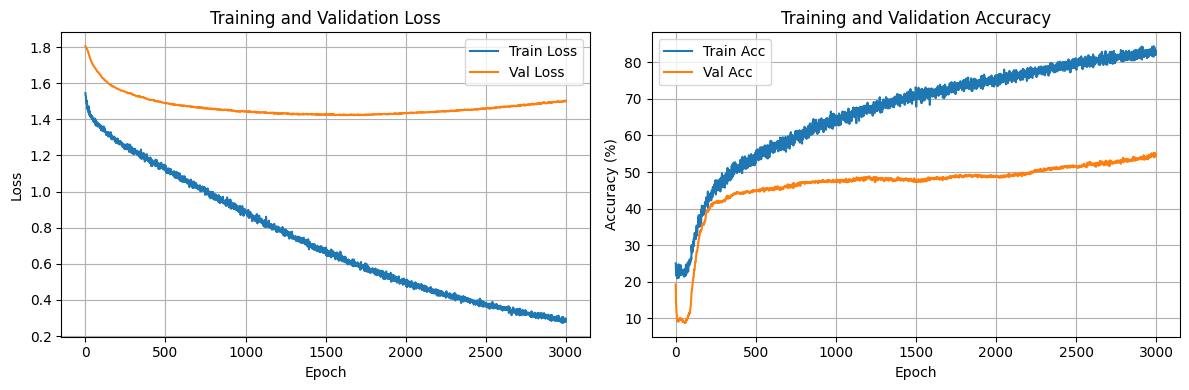

In [173]:
if __name__ == "__main__":
    history = train_model_with_valid(model, train_loader, val_loader, epochs=3000, use_weighted_loss=True, early_stopping=False)
    plot_history(history)

# Validate model.

Average loss: 1.1918 Val accuracy: 54.98%
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       361
           1       0.26      0.49      0.34        74
           2       0.58      0.22      0.32       200
           3       0.15      0.26      0.19        39
           4       0.19      0.49      0.27        59

    accuracy                           0.55       733
   macro avg       0.43      0.45      0.40       733
weighted avg       0.67      0.55      0.58       733



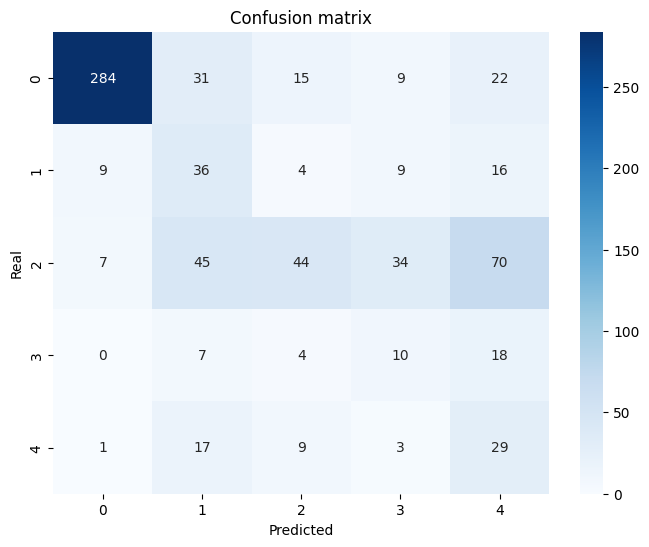

In [174]:
with torch.no_grad():
    model.eval()

    criterion = torch.nn.CrossEntropyLoss()
    
    val_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in val_loader:
        if use_cuda_if_available:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
    
        outputs = model(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    report = classification_report(all_labels, all_preds)

    confMatrix = confusion_matrix(all_labels, all_preds)

    print(f"Average loss: {avg_loss:.4f} Val accuracy: {accuracy*100:.2f}%")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion matrix")
    plt.ylabel("Real")
    plt.xlabel("Predicted")
    plt.show()